# Opertura d'una nova oficina i predicció de potencials localitzacions futures
 

|   INTEGRANTS                    | Arnau Muñoz Barrera     | Míriam López Sánchez       | Luis Martínez Zamora       | Marc Rodríguez Vitolo
| -------------------------- | ----------------------- | -------------------------- | -------------------------- | --------------------------

### 1. Objectius

L'objectiu d'aquest projecte es centra en buscar ubicacions idònies per obrir noves oficines de la Caixa d'Enginyers, valorant tant la possiblitat d'oficines fixes com oficinse mòbils que arriben a una determinada zona. A més, es desenvoluparà també un model predictiu amb l'ajuda d'IA que permeti identificar potencials localitzacions futures.

### 2. Font de les dades

Com a dades per analitzar en aquest projecte s'han agafat conjunts de dades extrets de fonts oficials: INE, BdE, Generalitat de Catalunya i propis de Caixa d'Enginyers.

### 3. Metodologia seguida

- Recerca de dades
- Anàlisi de dades amb python (realització de gràfiques i extracció d'estadístiques)
- Interpretació de resultats
- Creació d'un algoritme de creació de grafs
- Elecció de les millors ubicacions possibles
- Entrenament del model predictiu
- Test del model predictiu
- Justificació operativa i econòmica
- Extracció de conclusions


### 4. Anàlisi de les dades

Com a primer pas, caldrà importar totes les llibreries i utilitats que es faran servir en el desenvolupament del projecte:


In [1]:
%pip install pandas seaborn scikit-learn category_encoders scikit-optimize scipy openpyxl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import gist_heat_r
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm

import warnings
warnings.simplefilter(action='ignore')

Note: you may need to restart the kernel to use updated packages.


A continuació, es farà la importació dels datasets (arxius d'extensió **.xlsx**) a analitzar i s'analitzaran breument:

Estructura Interna de dataframe_bancs_per_provincia:  (53, 5)
     Columna1          Columna2            Columna3                Columna4  \
0  Provincia   Banco de España   Oficinas en España  Entidades de depósito    
1       Álava               NaN                 147                     147   
2    Albacete               NaN                 211                     211   
3     Alacant                 1                 603                     601   
4     Almería               NaN                 286                     285   

                            Columna5  
0  Otras entidades de crédito y EFC   
1                                NaN  
2                                NaN  
3                                  2  
4                                  1  


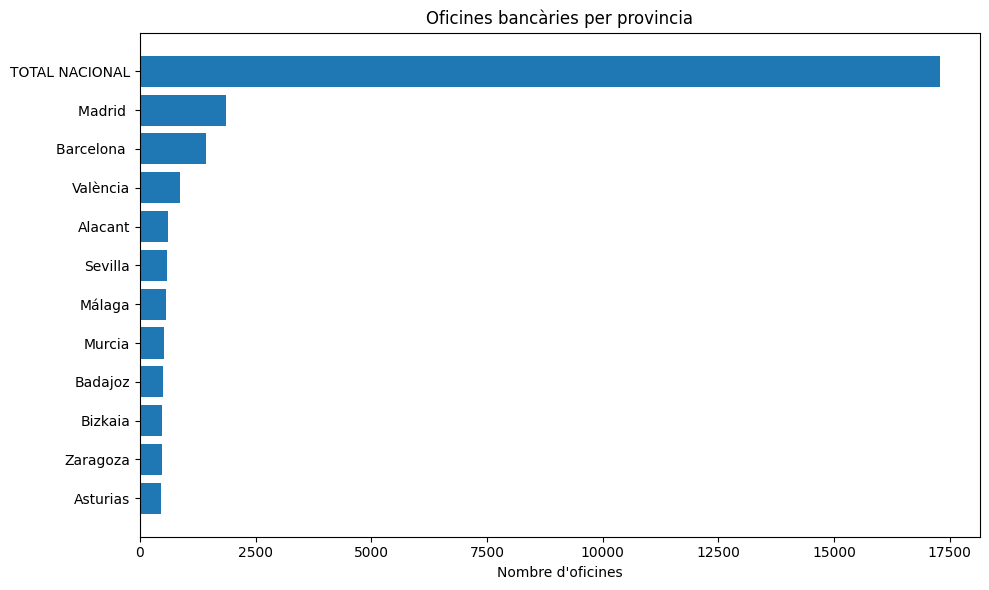

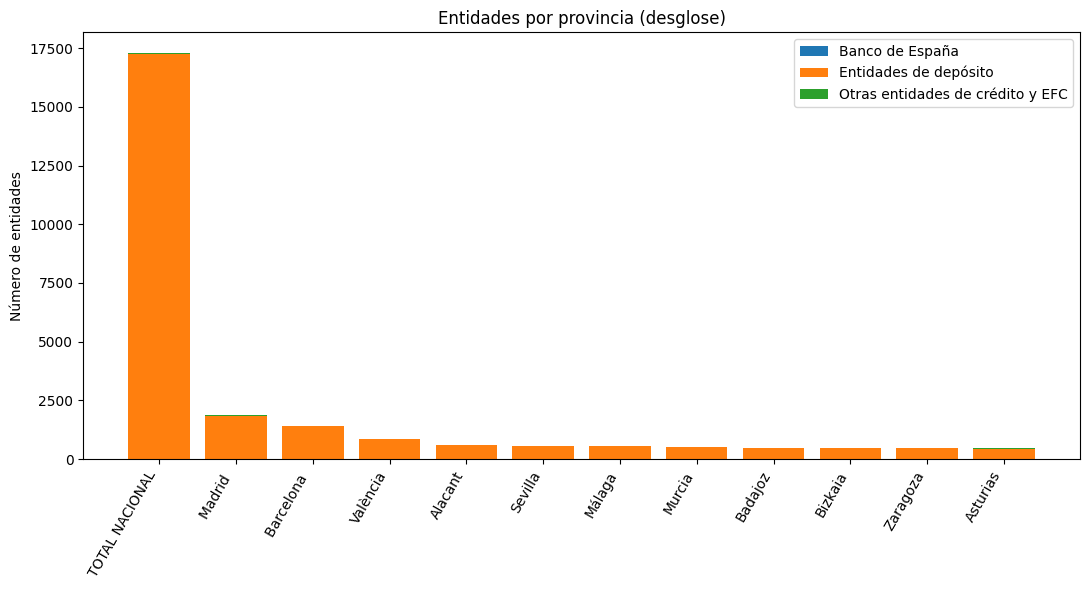

In [2]:
dataframe_bancs_per_provincia = pd.read_excel('data/BancsProvincia.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_bancs_per_provincia: ", dataframe_bancs_per_provincia.shape)

print(dataframe_bancs_per_provincia.head(5))

dfb = dataframe_bancs_per_provincia.copy()

if any(str(c).lower().startswith('columna') for c in dfb.columns):
    dfb.columns = dfb.iloc[0].tolist()
    dfb = dfb.iloc[1:].reset_index(drop=True)

dfb.columns = [str(c).strip() for c in dfb.columns]

name_col = 'Provincia'
cols_val = [
    'Banco de España',
    'Oficinas en España',
    'Entidades de depósito',
    'Otras entidades de crédito y EFC'
]

for c in cols_val:
    if c in dfb.columns:
        dfb[c] = pd.to_numeric(dfb[c], errors='coerce').fillna(0)

posibles_sel = ['Seleccion','Selección','SELECCION','SELECCIÓN','Plot','PLOT','Marcar','Include','Selected']
sel_col = next((c for c in dfb.columns if str(c).strip() in posibles_sel), None)

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    dfb_plot = dfb[dfb[sel_col].apply(_to_bool)].copy()
else:
    if 'Oficinas en España' in dfb.columns:
        dfb_plot = dfb.sort_values('Oficinas en España', ascending=False).head(12).copy()
    else:
        dfb_plot = dfb.copy()

if 'Oficinas en España' in dfb_plot.columns:
    plt.figure(figsize=(10,6))
    plt.barh(dfb_plot[name_col], dfb_plot['Oficinas en España'])
    plt.gca().invert_yaxis()
    plt.title('Oficines bancàries per provincia')
    plt.xlabel("Nombre d'oficines")
    plt.tight_layout()
    plt.show()

presentes = [c for c in ['Banco de España','Entidades de depósito','Otras entidades de crédito y EFC'] if c in dfb_plot.columns]
if presentes:
    plt.figure(figsize=(11,6))
    bottom = np.zeros(len(dfb_plot))
    for c in presentes:
        plt.bar(dfb_plot[name_col], dfb_plot[c], bottom=bottom, label=c)
        bottom += dfb_plot[c].values
    plt.xticks(rotation=60, ha='right')
    plt.title('Entidades por provincia (desglose)')
    plt.ylabel('Número de entidades')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Punts clau**

Arreu del territori espanyol es troben distribuïdes més de 17 000 oficines bancàries, sumant les de les diferents entitats que operen al país. Es pot veure que les tres provincies amb més volum d'oficines són Madrid, Barcelona i València.

In [3]:
dataframe_empresa_per_mida_and_provincia = pd.read_excel('data/EmpresesProvincia.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_empresa_per_mida_and_provincia: ", dataframe_empresa_per_mida_and_provincia.shape)

print(dataframe_empresa_per_mida_and_provincia.head(5))

df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

df = df[
    (df['CCAA'].str.strip().str.lower() != 'total') &      
    (df[prov_col].astype(str).str.strip().str.lower() == 'total')
]

columnas_total = [col for col in df.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))

df_grouped = df.groupby('CCAA', as_index=False)[columnas_total].sum()

plt.figure(figsize=(14, 7))

comunidades = df_grouped['CCAA'].values
num_comunidades = len(comunidades)
colors = cm.get_cmap('tab20', num_comunidades)

años = [int(col.split()[0]) for col in columnas_total]

for i, row in df_grouped.iterrows():
    comunidad = row['CCAA']
    valores = row[columnas_total].values.astype(float)
    plt.plot(años, valores, marker='o', color=colors(i), label=comunidad, linewidth=2)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'empreses per comunitat autònoma", fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.legend(title='Comunitat Autònoma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Estructura Interna de dataframe_empresa_per_mida_and_provincia:  (52, 15)
        Provincias/Any    2009    2010    2011    2012    2013    2014  \
0       01 Araba/Álava   21598   21138   20588   20055   19533   19471   
1          02 Albacete   27233   26800   26339   25996   26102   26609   
2  03 Alicante/Alacant  132637  131457  129564  127638  126113  130228   
3           04 Almería   42535   41548   40995   40516   39410   40208   
4             05 Ávila   11374   10735   10729   10307   10025   10146   

     2015    2016    2017    2018    2019    2020    2021    2022  
0   19919   18478   19108   18678   18851   18628   18771   17629  
1   26833   26906   26698   26275   26350   26221   26473   24852  
2  133056  135420  138909  142933  145431  144573  147286  136754  
3   41197   42314   42936   43406   44092   44437   45281   42724  
4   10074   10165   10166   10157   10198   10045   10099    9670  


KeyError: 'CCAA'

**Punts clau**

**⚠️ WARNING:** Les dades dels anys 2023-2025 han estat generades amb l'eina d'IA Aina perquè no s'han trobat en fonts oficials.

Es pot observar en el gràfic que la comunitat autònoma amb més empreses és Catalunya, seguida de prop per Andalucía i Madrid. Es pot destacar també la quantitat d'empreses situades a la Comunitat Valenciana.

In [ ]:
df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

provincias_catalunya = ['Barcelona', 'Girona', 'Lleida', 'Tarragona']
df_cat = df[df[prov_col].isin(provincias_catalunya)]

columnas_total = [col for col in df_cat.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))
años = [int(col.split()[0]) for col in columnas_total]

plt.figure(figsize=(12, 6))

colors = cm.get_cmap('tab10', len(provincias_catalunya))

for i, prov in enumerate(provincias_catalunya):
    datos_prov = df_cat[df_cat[prov_col] == prov]
    valores = datos_prov[columnas_total].values.flatten().astype(float)
    plt.plot(años, valores, marker='o', linewidth=2, color=colors(i), label=prov)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'empreses a Catalunya per provincies", fontsize=14)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.legend(title='Provincia')
plt.grid(True)
plt.tight_layout()
plt.show()

**Punts claus**

**⚠️ WARNING:** Les dades dels anys 2023-2025 han estat generades amb l'eina d'IA Aina perquè no s'han trobat en fonts oficials.

Tal i com es podria suposar, la provincia de Barcelona té la major concentració d'empreses, trobant-se al voltant de 450 000. Les altres tres provincies queden notablement per sota de les 100 000.

In [ ]:
dataframe_variacio_PIB_per_capita = pd.read_excel('data/PIBperCapita.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_variacio_PIB_per_capita: ", dataframe_variacio_PIB_per_capita.shape)

print(dataframe_variacio_PIB_per_capita.head(5))

df = dataframe_variacio_PIB_per_capita.copy()

year_cols = [c for c in df.columns
            if str(c).isdigit() and len(str(c)) == 4 and 2000 <= int(c) <= 2099]

name_col = df.columns[0]
type_col = df.columns[1]

posibles_sel = [
    'Plot','PLOT','Selección','SELECCIÓN','Seleccion','SELECCION',
    'Marcar','MARCAR','Include','INCLUDE','Selected','SELECTED',
    'Graficar','GRAFICAR','Mostrar','MOSTRAR'
]
sel_col = next((c for c in df.columns if str(c).strip() in posibles_sel), None)

ccaa = df[df[type_col].astype(str).str.upper().str.contains('CCAA')].copy()

excluir = {'ESPAÑA', 'TOTAL', 'TOTAL NACIONAL'}
ccaa = ccaa[~ccaa[name_col].astype(str).str.upper().isin(excluir)]

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    ccaa = ccaa[ccaa[sel_col].apply(_to_bool)]

melted = ccaa.melt(
    id_vars=[name_col, type_col],
    value_vars=year_cols,
    var_name='Año',
    value_name='PIB_per_capita'
)
melted['Año'] = melted['Año'].astype(int)

plt.figure(figsize=(11,6))
for region, sub in melted.groupby(name_col):
    plt.plot(sub['Año'], sub['PIB_per_capita'], label=region)

plt.title('Variació del PIB per càpita per comunitat autònoma')
plt.xlabel('Any')
plt.ylabel('PIB per càpita')
plt.legend(loc='best', ncol=2)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Cargar datos ---
df2 = pd.read_excel('data/PIB.xlsx', sheet_name=0)

# --- Detectar columnas de años ---
year_cols = [
    c for c in df2.columns
    if str(c).isdigit() and len(str(c)) == 4 and 2000 <= int(c) <= 2099
]

name_col = df2.columns[0]
type_col = df2.columns[1]

# --- Filtrar CCAA ---
ccaa2 = df2[df2[type_col].astype(str).str.upper().str.contains('CCAA')].copy()
ccaa2 = ccaa2[~ccaa2[name_col].astype(str).str.upper().isin({'ESPAÑA', 'TOTAL', 'TOTAL NACIONAL'})]

# --- Si hay columna de selección ---
posibles_sel = ['Plot','PLOT','Selección','SELECCIÓN','Seleccion','SELECCION','Marcar','MARCAR',
                'Include','INCLUDE','Selected','SELECTED','Graficar','GRAFICAR','Mostrar','MOSTRAR']

sel_col = next((c for c in df2.columns if str(c).strip() in posibles_sel), None)

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    ccaa2 = ccaa2[ccaa2[sel_col].apply(_to_bool)]

# --- Reorganizar ---
melted2 = ccaa2.melt(
    id_vars=[name_col, type_col],
    value_vars=year_cols,
    var_name='Año',
    value_name='PIB'
)

melted2['Año'] = melted2['Año'].astype(int)
melted2['PIB'] = pd.to_numeric(melted2['PIB'], errors='coerce')

# --- Gráfico con la misma estética que el anterior ---
fig, ax = plt.subplots(figsize=(12, 7))

for region, sub in melted2.groupby(name_col):
    ax.plot(sub['Año'], sub['PIB'], marker='o', markersize=4, label=region)

# X solo con enteros
ax.set_xticks(sorted(melted2['Año'].unique()))
ax.set_xticklabels(sorted(melted2['Año'].unique()))

ax.set_title('Variació del PIB per comunitat autònoma')
ax.set_xlabel('Any')
ax.set_ylabel('PIB')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


**Punts clau**

De les dades del PIB no es poden extreure conclusions significatives degut a que l'evolució d'aquest és similar en totes les provincies. Tot i així, es pot remarcar que Catalunya es troba dins les comunitats amb un PIB més elevat.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('data/Habitants.xlsx')

df_ccaa = df[df['TIPO'] == 'CCAA'].copy()

df_ccaa['CCAA'] = df_ccaa['CCAA'].str.strip()
df_ccaa = df_ccaa.set_index('CCAA').drop('TIPO', axis=1)

df_plot = df_ccaa.T
df_plot.index = df_plot.index.astype(int)

# Graficar
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_plot)

ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot.index.astype(str))

ax.set_title('Evolució de la població per CCAA')
ax.set_xlabel('Any')
ax.set_ylabel('Població')

ax.legend(
    df_plot.columns,
    title="CCAA",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


**Punts Clau**

Al igual que amb el PIB, les dades de població evolucionen de manera pràcticament igual a tot el territori espanyol. A continuació, es mostra un gràfic amb les dades referents a les provinices catalanes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('data/Habitants.xlsx')

df_ccaa = df[df['TIPO'] == 'PROVINCIA CATALUNYA'].copy()

df_ccaa['CCAA'] = df_ccaa['CCAA'].str.strip()
df_ccaa = df_ccaa.set_index('CCAA').drop('TIPO', axis=1)

df_plot = df_ccaa.T
df_plot.index = df_plot.index.astype(int)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_plot)

ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot.index.astype(str))

ax.set_title('Evolució de la població per CCAA')
ax.set_xlabel('Any')
ax.set_ylabel('Població')

ax.legend(
    df_plot.columns,
    title="Provincies",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


### 5. Conclusions anàlisi de dades

Donats els gràfics i les sèries disponibles sobre factors clau a Espanya —com ara el PIB i el creixement de la població, que mostren una distribució desigual—, es conclou que el focus d’anàlisi amb més potencial es troba a Catalunya. Es tracta d’una de les zones més poblades, amb dinàmica de creixement i una elevada concentració d’entitats rellevants per al PIB.

A més, segons dades internes de la Caixa d'Enginyers, la distribució de socis per regió és la següent:

**⚠️ WARNING:** Distribució ficticia de socis per regions (Temporal)

| Regions              | Socis | % sobre total | Variació interanual | Nota breu                                         |
|---------------------------------|-------:|--------------:|---------------------:|----------------------------------------------------|
| Àrea Metropolitana de Barcelona | 72.000 | 60,0%         | +3,2%                | Alta concentració urbana i hubs tecnològics      |
| Comarques Gironines            | 12.600 | 10,5%         | +4,1%                | Creixement en renovables i turisme de qualitat     |
| Camp de Tarragona              | 10.800 | 9,0%          | +3,7%                | Indústria química i logística portuaria            |
| Penedès                        | 8.400  | 7,0%          | +3,5%                | Agroalimentari i teixit exportador                |
| Comarques Centrals             | 7.200  | 6,0%          | +2,8%                | Pymes industrials diversificades                  |
| Ponent                         | 4.800  | 4,0%          | +2,4%                | Agroindústria i energia                            |
| Terres de l’Ebre               | 2.400  | 2,0%          | +2,0%                | Transició energètica i serveis                  |
| Alt Pirineu i Aran             | 1.800  | 1,5%          | +1,7%                | Turisme sostenible i economia de montanya           |
| **Total**                      | **120.000** | **100%**   | —                    | —                                                  |


### 6. Generació de dades amb LLM
Com que algunes de les dades extretes de fonts oficials no tenen informació suficient dels útlims anys, s'ha optat per utilitzar l'eina Aina per generar dades corresponents a aquests. S'adjunta un exemple de com s'ha fet servir. Les dades generades han estat el nombre d'empreses per comunitat autònoma i la població per provincies i comunitat autònoma entre els anys 2023 i 2025.

<p align="center">
  <img src="assets/Eina_AINA.jpeg" alt="Example" width="600"/>
</p>




### 7. Propostes
#### 7.1 Proposta Nivell Bàsic
Pel nivell bàsic, després de valorar entre diverses opcions, s'ha decidit plantejar la implementació d'una oficina mòbil i proposar-ne la ruta òptima. Per fer-ho, s'ha dissenyat un algoritme que crea un graf i, a partir d'això i diversa informació, escull els municipis òptims per poder situar la unitat mòbil o oficina. 







##### Descripció del funcionament de l’algoritme
El codi té com a objectiu seleccionar la ubicació òptima d’oficines bancàries fixes i mòbils per maximitzar la cobertura de la població d’una regió.
Per fer-ho, treballa amb un graf de municipis, on cada node representa un municipi i les arestes representen la seva proximitat geogràfica.

**Dades d’entrada**

Per crear el graf cal disposar de:

- Nom del municipi
- Codi o identificador únic
- Població (en diferents franges d’edat o total)
- Coordenades UTM (X, Y)

A partir d'aquestes dades es genera un graf per poder treballar-hi.

**Funcionament de l’algorisme**

El cor del programa és la classe BankCoverageOptimizer, que implementa un algorisme golafre (greedy) per decidir on situar oficines.

<u>Inicialització</u>

Cada node es marca com a no cobert i sense cap oficina associada.

<u>Càlcul de cobertura</u>

Per a cada node, es calcula una puntuació de cobertura:

- Suma la població dels nodes dins d’un radi determinat.

- Dona més pes als municipis més propers (factor 1/(distància+1)/home/mmarcrv/Hackaton-UAB-2025/assets/girona_bank_coverage.png).

- Selecció d’oficines fixes

- Es tria el node amb puntuació més alta.

- Es marca com a oficina física i cobreix tots els nodes dins del radi.

Es repeteix fins arribar al nombre d’oficines desitjat.

<u>Selecció d’oficines mòbils</u>

Es repeteix el mateix procés, però només amb els nodes no coberts i amb un radi més petit.

<u>Resultats</u>

Hem probat aquest algorisme en les 3 provincies de Catalunya on Caixa d'Enginyers no té tanta influència. Els resultats de l'algorisme són els següents:

[GRAF GENERAT I SELECCIÓ PER GIRONA](/home/mmarcrv/Hackaton-UAB-2025/assets/girona_bank_coverage.png)

[GRAF GENERAT I SELECCIÓ PER LLEIDA](/home/mmarcrv/Hackaton-UAB-2025/assets/lleida_bank_coverage.png)

[GRAF GENERAT I SELECCIÓ PER TARRAGONA](/home/mmarcrv/Hackaton-UAB-2025/assets/tarragona_bank_coverage.png)


#### 7.2 Proposta Nivell Avançat

**Objectiu.** Proposar un flux de modelatge de nivell avançat, amb *pipeline* reproduïble, validació creuada i 
optimització d'hiperparàmetres. El disseny és agnòstic al conjunt de dades i es pot adaptar ràpidament canviant els
noms de les columnes.

**Enfocament.**
- **Preprocessament amb `ColumnTransformer`**: estandardització per a variables numèriques i *one‑hot encoding* per a variables categòriques.
- **Model principal**: `HistGradientBoosting` (classe/regressió), eficient i robust, adequat per a grans conjunts de dades.
- **Avaluació**: validació creuada (estratificada si és classificació) amb mètriques apropiades.
- **Cerca d’hiperparàmetres**: `RandomizedSearchCV` per explorar l’espai de paràmetres de forma eficient.
- **Persistència**: guardem el millor *pipeline* amb `joblib` per a desplegament o reproducció.

> **Com usar-ho**: definiu `TARGET` i la llista `FEATURES` d'acord amb el vostre *dataset* (p.ex. `df`). Si el problema és
> de classificació, assegureu-vos que `y` és categòrica (o amb valors discrets). Executeu la cel·la de codi següent.


In [ ]:
import pandas as pd

file_paths = [
    '/content/Densidad.xlsx',
    '/content/EmpresesProvincia.xlsx',
    '/content/HipotequesAnuals(2009-2022).xlsx',
    '/content/IPC.xlsx',
    '/content/PIB.xlsx'
]

dataframes = {}

for path in file_paths:
    df_name = path.split('/')[-1].split('.')[0]  # Extract name from file path
    print(f"\n--- Processing {df_name} ---")
    try:
        df = pd.read_excel(path)
        dataframes[df_name] = df
        print(f"\nInfo for {df_name}:")
        df.info()
        print(f"\nHead of {df_name}:")
        display(df.head())
    except Exception as e:
        print(f"Error processing {df_name}: {e}")


In [ ]:
melted_dataframes = {}

# Define mappings for column names to handle variations across dataframes
province_column_mapping = {
    'Densidad': 'Provincia/Any',
    'EmpresesProvincia': 'Provincias/Any',
    'HipotequesAnuals(2009-2022)': 'Provincia',
    'IPC': 'Provincia/Any',
    'PIB': 'Provincia/Any'
}

value_column_name_mapping = {
    'Densidad': 'Densidad',
    'EmpresesProvincia': 'Empreses',
    'HipotequesAnuals(2009-2022)': 'Hipoteques',
    'IPC': 'IPC',
    'PIB': 'PIB'
}

for df_name, df in dataframes.items():
    print(f"\nProcessing DataFrame: {df_name}")

    # a. Identify the column containing province names
    province_col = province_column_mapping.get(df_name)
    if province_col is None:
        print(f"Warning: Province column not found for {df_name}. Skipping.")
        continue

    # Create a copy to avoid SettingWithCopyWarning
    df_copy = df.copy()

    # b. Create 'PROV_ID' by extracting the first two numerical digits
    # Ensure the column is string type before applying str.extract
    df_copy['PROV_ID'] = df_copy[province_col].astype(str).str.extract(r'^(\d{2})').astype(int)

    # Columns that represent years will be numeric and not the province column
    year_columns = [col for col in df_copy.columns if col.isdigit()]

    # c. Melt the DataFrame from wide format to long format
    value_column_name = value_column_name_mapping.get(df_name)
    if value_column_name is None:
        print(f"Warning: Value column name not defined for {df_name}. Skipping.")
        continue

    melted_df = pd.melt(df_copy,
                        id_vars=[province_col, 'PROV_ID'],
                        value_vars=year_columns,
                        var_name='Year',
                        value_name=value_column_name)

    # d. Convert the 'Year' column in the melted DataFrame to integer type
    melted_df['Year'] = melted_df['Year'].astype(int)

    # e. Store the processed and melted DataFrame
    melted_dataframes[value_column_name] = melted_df
    print(f"Melted {df_name} DataFrame head:")
    display(melted_df.head())
    print(f"Melted {df_name} DataFrame info:")
    melted_df.info()

print("\nAll DataFrames have been processed and melted.")

In [ ]:
import re

def clean_province_name(province_name):
    """Removes leading/trailing numbers and spaces from a province name."""
    # Remove numbers and spaces from the beginning and end of the string
    cleaned_name = re.sub(r'^\d+\s*|\s*\d+$', '', str(province_name))
    return cleaned_name.strip()

province_name_to_id = {}

# Iterate through the melted_dataframes to extract province names and their PROV_IDs
for original_df_name, melted_df in melted_dataframes.items():
    # Find the actual province column name in the current melted_df
    # It will be one of 'Provincia/Any', 'Provincias/Any', or 'Provincia'
    province_col_name_in_melted_df = None
    if 'Provincia/Any' in melted_df.columns:
        province_col_name_in_melted_df = 'Provincia/Any'
    elif 'Provincias/Any' in melted_df.columns:
        province_col_name_in_melted_df = 'Provincias/Any'
    elif 'Provincia' in melted_df.columns:
        province_col_name_in_melted_df = 'Provincia'
    else:
        print(f"Warning: Could not find province column for {original_df_name}. Skipping.")
        continue

    # Get unique province name and PROV_ID pairs
    unique_provinces = melted_df[[province_col_name_in_melted_df, 'PROV_ID']].drop_duplicates()

    for index, row in unique_provinces.iterrows():
        original_name = row[province_col_name_in_melted_df]
        province_id = row['PROV_ID']
        cleaned_name = clean_province_name(original_name)
        # Add to dictionary if cleaned name is not empty and PROV_ID is not already mapped to a different name
        if cleaned_name and cleaned_name not in province_name_to_id and province_id is not None:
            province_name_to_id[cleaned_name] = province_id

# Sort the dictionary by PROV_ID for consistent output
sorted_province_name_to_id = dict(sorted(province_name_to_id.items(), key=lambda item: item[1]))

print("Province Name to ID mapping:")
print(sorted_province_name_to_id)

In [ ]:
import functools

# Get the first DataFrame name (which is also the value column name) from melted_dataframes
first_value_column_name = next(iter(melted_dataframes))
first_df = melted_dataframes[first_value_column_name]

# Initialize general_df with PROV_ID, Year, and the first value column
general_df = first_df[['PROV_ID', 'Year', first_value_column_name]].copy()

# Iterate through the rest of the melted DataFrames and merge them
for current_value_column_name, df_to_merge_from_dict in melted_dataframes.items():
    if current_value_column_name == first_value_column_name:
        continue

    # The key of melted_dataframes (current_value_column_name) is already the name of the value column
    # in the current df_to_merge_from_dict

    # Select only the relevant columns for merging
    df_to_merge_subset = df_to_merge_from_dict[['PROV_ID', 'Year', current_value_column_name]]

    general_df = pd.merge(general_df,
                          df_to_merge_subset,
                          on=['PROV_ID', 'Year'],
                          how='outer')

print("Merged general_df head:")
display(general_df.head())

print("Merged general_df info:")
general_df.info()

In [ ]:
column_rename_mapping = {
    'PROV_ID': 'provincia',
    'Year': 'año',
    'Densidad': 'densidad',
    'Empreses': 'empreses',
    'Hipoteques': 'hipoteques',
    'IPC': 'IPD',
    'PIB': 'PIB'
}

general_df = general_df.rename(columns=column_rename_mapping)

# Define the desired order of columns
desired_column_order = [
    'provincia',
    'año',
    'densidad',
    'empreses',
    'hipoteques',
    'IPD',
    'PIB'
]

# Reorder the columns
general_df = general_df[desired_column_order]

print("general_df after renaming and reordering columns:")
display(general_df.head(-5))
general_df.info()

In [ ]:
# Calculate the mean 'PIB' for each year, ignoring existing NaN values
yearly_pib_means = general_df.groupby('año')['PIB'].mean()

# Fill NaN values in the 'PIB' column with the corresponding yearly mean
general_df['PIB'] = general_df.apply(
    lambda row: yearly_pib_means[row['año']] if pd.isna(row['PIB']) else row['PIB'],
    axis=1
)

print("general_df after imputing missing 'PIB' values:")
display(general_df.head(-5))
general_df.info()


In [ ]:
socios_df = pd.read_excel('/content/socios_caixa_enginyers_provincias_EXTENDIDO.xlsx')

print("\nInfo for socios_caixa_enginyers_provincias_unica_hoja:")
socios_df.info()

print("\nHead of socios_caixa_enginyers_provincias_unica_hoja:")
display(socios_df.head())


In [ ]:
import pandas as pd

# Assuming socios_df and sorted_province_name_to_id are already defined and available from previous steps.
# If not, they would need to be re-loaded or re-created here.

# 1. Melt the socios_df to a long format
province_cols = [
    'Barcelona', 'Girona', 'Lleida', 'Tarragona', 'Madrid', 'Valencia',
    'Alicante', 'Zaragoza', 'Bizkaia', 'Sevilla', 'Málaga', 'Illes Balears'
]

# Ensure only relevant province columns are melted, excluding aggregates like 'Total (miles)'
socios_melted_df = pd.melt(socios_df,
                           id_vars=['Año'],
                           value_vars=province_cols,
                           var_name='ProvinceName',
                           value_name='Socios')

# Create an alias mapping for inconsistent province names
province_name_aliases = {
    'Valencia': 'Valencia/València',
    'Alicante': 'Alicante/Alacant',
    'Illes Balears': 'Balears, Illes' # Correctly map 'Illes Balears' to 'Balears, Illes'
}

# Apply the alias mapping to ProvinceName, if no alias exists, use the original name
socios_melted_df['MappedProvinceName'] = socios_melted_df['ProvinceName'].replace(province_name_aliases)

# 2. Map 'MappedProvinceName' to numerical 'Provincia' (PROV_ID) using the existing sorted_province_name_to_id dictionary
socios_melted_df['Provincia'] = socios_melted_df['MappedProvinceName'].map(sorted_province_name_to_id)

# 3. Rename 'Año' to 'año' for consistency and convert 'Provincia' and 'año' to integer type
socios_melted_df = socios_melted_df.rename(columns={'Año': 'año'})
socios_melted_df['año'] = socios_melted_df['año'].astype(int)
socios_melted_df['Provincia'] = socios_melted_df['Provincia'].astype('Int64') # Using 'Int64' to allow for NaN if mapping fails

# 4. Select only the desired columns: 'Provincia', 'año', 'Socios'
socios_processed_df = socios_melted_df[['Provincia', 'año', 'Socios']].copy()

print("Processed `socios_processed_df` head:")
display(socios_processed_df.head())

print("Processed `socios_processed_df` info:")
socios_processed_df.info()


In [ ]:
# Perform an inner merge to get only provinces present in both dataframes
common_provinces_df = pd.merge(general_df,
                               socios_processed_df,
                               left_on=['provincia', 'año'],
                               right_on=['Provincia', 'año'],
                               how='inner')

# Drop the redundant 'Provincia' column from socios_processed_df after merge
common_provinces_df = common_provinces_df.drop(columns=['Provincia'])

# Rename the 'Socios' column to 'socis' as requested
common_provinces_df = common_provinces_df.rename(columns={'Socios': 'socis'})

print("New DataFrame with common provinces and 'socis' feature head:")
display(common_provinces_df.head())

print("New DataFrame with common provinces and 'socis' feature info:")
print(common_provinces_df.info())
common_provinces_df["socis"].describe()


In [ ]:
df_final = common_provinces_df.copy()

# 1. Sort the DataFrame by 'provincia' and 'año'
df_final = df_final.sort_values(by=['provincia', 'año']).reset_index(drop=True)

# 2. Rename 'socis' to 'original_socis' to preserve the original values
df_final = df_final.rename(columns={'socis': 'original_socis'})

# 3. Calculate 'dif_socis' (difference in the number of members from the previous year)
df_final['dif_socis'] = df_final.groupby('provincia')['original_socis'].diff()

# 4. Handle 'dif_socis' for the first year (2009)
#    For 2009, if original_socis is not 0, compute the mean of differences for that province
#    If original_socis is 0, set dif_socis to 0
for provincia_id in df_final['provincia'].unique():
    # Get the slice for the current province
    prov_df = df_final[df_final['provincia'] == provincia_id]

    # Check if 2009 exists and get its index
    first_year_row_index = prov_df[prov_df['año'] == 2009].index

    if not first_year_row_index.empty:
        idx = first_year_row_index[0]
        original_socis_2009 = df_final.loc[idx, 'original_socis']

        if original_socis_2009 != 0:
            # Calculate the mean of differences for this province (excluding the initial NaN)
            mean_diff = prov_df['dif_socis'].dropna().mean()
            df_final.loc[idx, 'dif_socis'] = mean_diff
        else:
            # If original_socis for 2009 is 0, set dif_socis to 0
            df_final.loc[idx, 'dif_socis'] = 0


# 5. Calculate 'antiguitat'
def calculate_antiguitat(group):
    first_non_zero_socis_year = None
    for index, row in group.iterrows():
        if row['original_socis'] > 0:
            first_non_zero_socis_year = row['año']
            break

    if first_non_zero_socis_year is None:
        # All socis are 0 for this province, so antiguitat is always 0
        group['antiguitat'] = 0
    else:
        group['antiguitat'] = group['año'].apply(
            lambda current_year: (current_year - first_non_zero_socis_year + 1) if current_year >= first_non_zero_socis_year else 0
        )
    return group

df_final = df_final.groupby('provincia', group_keys=False).apply(calculate_antiguitat)


print("Final DataFrame with new features head:")
display(df_final.head())

print("Final DataFrame info:")
df_final.info()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
from datetime import datetime
import os # Import os module

warnings.filterwarnings('ignore')
np.random.seed(42)

# ============================================================================
# PARTE 1: FEATURE ENGINEERING
# ============================================================================

def engineer_features(df, known_provinces=None):
    """
    Crea features adicionales para mejorar la predicción.
    Ahora maneja correctamente provincias nuevas y antigüedad 0.
    """
    print("\n" + "="*80)
    print("FEATURE ENGINEERING (VERSIÓN EXTENDIDA)")
    print("="*80 + "\n")

    df = df.copy()
    df = df.sort_values(['provincia', 'año']).reset_index(drop=True)

    # Evitar errores si antiguitat = 0
    df['antiguitat'] = df['antiguitat'].replace(0, 1)

    # 1. Features temporales
    df['año_normalizado'] = (df['año'] - df['año'].min()) / (df['año'].max() - df['año'].min())

    # 2. Features de lag
    for col in ['densidad', 'empreses', 'hipoteques', 'IPD', 'PIB', 'original_socis']:
        df[f'{col}_lag1'] = df.groupby('provincia')[col].shift(1)

    # 3. Tasas de crecimiento y volatilidad
    df['crecimiento_historico_3y'] = df.groupby('provincia')['dif_socis'].transform(lambda x: x.rolling(3, 1).mean())
    df['crecimiento_historico_5y'] = df.groupby('provincia')['dif_socis'].transform(lambda x: x.rolling(5, 1).mean())
    df['volatilidad_crecimiento'] = df.groupby('provincia')['dif_socis'].transform(lambda x: x.rolling(3, 1).std()).fillna(0)

    # 4. Features de madurez
    df['antiguitat_squared'] = df['antiguitat'] ** 2
    df['antiguitat_log'] = np.log1p(df['antiguitat'])

    # 5. Ratios
    df['empreses_per_capita'] = df['empreses'] / (df['densidad'] + 1)
    df['hipoteques_per_capita'] = df['hipoteques'] / (df['densidad'] + 1)
    df['PIB_per_capita'] = df['PIB'] / (df['densidad'] + 1)
    df['penetracion_mercado'] = df['original_socis'] / (df['densidad'] + 1)

    # 6. Cambios interanuales
    for col in ['PIB', 'empreses', 'hipoteques', 'IPD']:
        df[f'delta_{col}'] = df.groupby('provincia')[col].diff()
        df[f'pct_change_{col}'] = df.groupby('provincia')[col].pct_change().fillna(0)

    # 7. Dummies de provincia
    print("Creando dummies de provincia...")
    provincia_dummies = pd.get_dummies(df['provincia'], prefix='prov', drop_first=True)

    # Si hay provincias nuevas (no vistas antes), agregarlas
    if known_provinces is not None:
        for prov in known_provinces:
            if prov not in provincia_dummies.columns:
                provincia_dummies[prov] = 0

    df = pd.concat([df, provincia_dummies], axis=1)

    # 8. Indicador de crisis
    df['periodo_crisis'] = ((df['año'] >= 2008) & (df['año'] <= 2012)).astype(int)

    # 9. Interacciones
    df['antiguitat_x_densidad'] = df['antiguitat'] * df['densidad']
    df['antiguitat_x_PIB'] = df['antiguitat'] * df['PIB']
    df['empreses_x_IPD'] = df['empreses'] * df['IPD']

    print(f"✓ Feature engineering completado ({df.shape[1]} columnas totales)")
    return df


# ============================================================================
# PARTE 2: PREPARACIÓN DE DATOS PARA MODELOS
# ============================================================================

def prepare_train_test_split(df, test_year=None):
    """
    Prepara datos para entrenamiento y test.
    Si test_year es None, usa validación temporal en todo el dataset.
    """
    print("\n" + "="*80)
    print("PREPARACIÓN DE DATOS")
    print("="*80 + "\n")

    # Eliminar filas con NaN en features críticos (primer año de cada provincia)
    df = df.dropna(subset=['original_socis_lag1'])

    # Definir features
    exclude_cols = ['provincia', 'año', 'dif_socis', 'original_socis']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    print(f"Features seleccionados: {len(feature_cols)}")
    print(f"  {feature_cols[:10]}... (mostrando primeros 10)")

    # Split warm vs cold start
    df_warm = df[df['antiguitat'] > 1].copy()  # Con histórico
    df_cold = df[df['antiguitat'] == 1].copy()  # Año 1 (cold start)

    print(f"\nDataset Warm Start (antiguitat > 1): {len(df_warm)} registros")
    print(f"Dataset Cold Start (antiguitat = 1): {len(df_cold)} registros")

    if test_year:
        train_warm = df_warm[df_warm['año'] < test_year]
        test_warm = df_warm[df_warm['año'] >= test_year]

        train_cold = df_cold[df_cold['año'] < test_year]
        test_cold = df_cold[df_cold['año'] >= test_year]

        print(f"\nSplit temporal (test_year={test_year}):")
        print(f"  Train Warm: {len(train_warm)}, Test Warm: {len(test_warm)}")
        print(f"  Train Cold: {len(train_cold)}, Test Cold: {len(test_cold)}")

        return {
            'train_warm': (train_warm[feature_cols], train_warm['dif_socis']),
            'test_warm': (test_warm[feature_cols], test_warm['dif_socis']),
            'train_cold': (train_cold[feature_cols], train_cold['dif_socis']),
            'test_cold': (test_cold[feature_cols], test_cold['dif_socis']),
            'feature_cols': feature_cols
        }
    else:
        return {
            'warm': (df_warm[feature_cols], df_warm['dif_socis']),
            'cold': (df_cold[feature_cols], df_cold['dif_socis']),
            'feature_cols': feature_cols
        }


# ============================================================================
# PARTE 3: MODELO WARM START (Con Histórico)
# ============================================================================

class WarmStartModel:
    """
    Modelo para predecir crecimiento en provincias con presencia establecida.
    """

    def __init__(self, model_type='xgboost'):
        self.model_type = model_type
        self.model = None
        self.scaler = RobustScaler()
        self.feature_cols = None

    def train(self, X, y, cv_splits=5):
        """
        Entrena modelo con validación temporal.
        """
        print(f"\n{'='*80}")
        print(f"WARM START MODEL: {self.model_type.upper()}")
        print(f"{'='*80}\n")

        # Escalar features
        X_scaled = self.scaler.fit_transform(X)
        self.feature_cols = X.columns.tolist()

        # TimeSeriesSplit para validación
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        rmse_scores = []
        mae_scores = []

        print("Validación cruzada temporal:")
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Entrenar
            if self.model_type == 'xgboost':
                model = xgb.XGBRegressor(
                    learning_rate=0.05,
                    n_estimators=500,
                    max_depth=6,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=1.0,
                    reg_lambda=1.0,
                    random_state=42
                )
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

            elif self.model_type == 'lightgbm':
                model = lgb.LGBMRegressor(
                    learning_rate=0.05,
                    n_estimators=500,
                    max_depth=6,
                    num_leaves=31,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=1.0,
                    reg_lambda=1.0,
                    random_state=42,
                    verbose=-1
                )
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)

            rmse_scores.append(rmse)
            mae_scores.append(mae)

            print(f"  Fold {fold}: RMSE={rmse:.2f}, MAE={mae:.2f}")

        print(f"\nCV Results:")
        print(f"  RMSE: {np.mean(rmse_scores):.2f} \u00b1 {np.std(rmse_scores):.2f}")
        print(f"  MAE:  {np.mean(mae_scores):.2f} \u00b1 {np.std(mae_scores):.2f}")

        # Entrenar modelo final con todos los datos
        if self.model_type == 'xgboost':
            self.model = xgb.XGBRegressor(
                learning_rate=0.05,
                n_estimators=500,
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42
            )
        elif self.model_type == 'lightgbm':
            self.model = lgb.LGBMRegressor(
                learning_rate=0.05,
                n_estimators=500,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                verbose=-1
            )

        self.model.fit(X_scaled, y)
        print(f"\n\u2713 Modelo final entrenado con {len(X)} registros")

        return {
            'rmse_mean': np.mean(rmse_scores),
            'rmse_std': np.std(rmse_scores),
            'mae_mean': np.mean(mae_scores),
            'mae_std': np.std(mae_scores)
        }

    def predict(self, X):
        """Predice crecimiento."""
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)


# ============================================================================
# PARTE 4: MODELO COLD START (Nuevas Zonas)
# ============================================================================

class ColdStartModel:
    """
    Modelo para predecir crecimiento inicial en nuevas zonas sin histórico.
    Combina XGBoost + KNN para mayor robustez.
    """

    def __init__(self):
        self.model_xgb = None
        self.model_knn = None
        self.scaler = RobustScaler()
        self.feature_cols = None
        self.X_train_scaled = None  # Para KNN
        self.y_train = None

    def train(self, X, y, cv_splits=3):
        """
        Entrena modelos para cold start.
        """
        print(f"\n{'='*80}")
        print(f"COLD START MODEL: Ensemble XGBoost + KNN")
        print(f"{'='*80}\n")

        # Escalar
        X_scaled = self.scaler.fit_transform(X)
        self.feature_cols = X.columns.tolist()
        self.X_train_scaled = X_scaled
        self.y_train = y

        # TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        rmse_xgb = []
        rmse_knn = []
        rmse_ensemble = []

        print("Validación cruzada temporal (Cold Start):")
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
            X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # XGBoost
            model_xgb = xgb.XGBRegressor(
                learning_rate=0.1,
                n_estimators=300,
                max_depth=4,
                min_child_weight=5,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=2.0,
                reg_lambda=2.0,
                random_state=42
            )
            model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            pred_xgb = model_xgb.predict(X_val)

            # KNN
            # FIX: Reduced n_neighbors from 5 to 2 because the minimum training set size in TimeSeriesSplit was 2.
            model_knn = KNeighborsRegressor(n_neighbors=2, weights='distance')
            model_knn.fit(X_tr, y_tr)
            pred_knn = model_knn.predict(X_val)

            # Ensemble (70% XGB + 30% KNN)
            pred_ensemble = 0.7 * pred_xgb + 0.3 * pred_knn

            rmse_xgb.append(np.sqrt(mean_squared_error(y_val, pred_xgb)))
            rmse_knn.append(np.sqrt(mean_squared_error(y_val, pred_knn)))
            rmse_ensemble.append(np.sqrt(mean_squared_error(y_val, pred_ensemble)))

            print(f"  Fold {fold}:")
            print(f"    XGBoost: RMSE={rmse_xgb[-1]:.2f}")
            print(f"    KNN:     RMSE={rmse_knn[-1]:.2f}")
            print(f"    Ensemble: RMSE={rmse_ensemble[-1]:.2f}")

        print(f"\nCV Results (Cold Start):")
        print(f"  XGBoost:  RMSE={np.mean(rmse_xgb):.2f} \u00b1 {np.std(rmse_xgb):.2f}")
        print(f"  KNN:      RMSE={np.mean(rmse_knn):.2f} \u00b1 {np.std(rmse_knn):.2f}")
        print(f"  Ensemble: RMSE={np.mean(rmse_ensemble):.2f} \u00b1 {np.std(rmse_ensemble):.2f}")

        # Entrenar modelos finales
        self.model_xgb = xgb.XGBRegressor(
            learning_rate=0.1,
            n_estimators=300,
            max_depth=4,
            min_child_weight=5,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=2.0,
            reg_lambda=2.0,
            random_state=42
        )
        self.model_xgb.fit(X_scaled, y)

        # FIX: Reduced n_neighbors from 5 to 2 for the final model training as well.
        self.model_knn = KNeighborsRegressor(n_neighbors=2, weights='distance')
        self.model_knn.fit(X_scaled, y)

        print(f"\n\u2713 Modelos Cold Start entrenados con {len(X)} registros")

        return {
            'rmse_xgb': np.mean(rmse_xgb),
            'rmse_knn': np.mean(rmse_knn),
            'rmse_ensemble': np.mean(rmse_ensemble)
        }

    def predict(self, X):
        """
        Predice crecimiento inicial (ensemble).
        """
        X_scaled = self.scaler.transform(X)
        pred_xgb = self.model_xgb.predict(X_scaled)
        pred_knn = self.model_knn.predict(X_scaled)
        return 0.7 * pred_xgb + 0.3 * pred_knn


# ============================================================================
# PARTE 5: PIPELINE UNIFICADO
# ============================================================================

class GrowthPredictionPipeline:
    """
    Pipeline robusto para nuevas provincias y antigüedad 0.
    """
    def __init__(self):
        self.warm_model = None
        self.cold_model = None
        self.feature_cols = None
        self.known_province_dummies = None

    def train(self, df):
        print("\n" + "#"*80)
        print("# ENTRENANDO PIPELINE COMPLETO (ROBUSTO)")
        print("#"*80 + "\n")

        # Feature engineering y guardar columnas dummy
        df_engineered = engineer_features(df)
        self.known_province_dummies = [c for c in df_engineered.columns if c.startswith("prov_")]

        # Preparar datos
        data = prepare_train_test_split(df_engineered)

        # Entrenar modelos
        self.warm_model = WarmStartModel('xgboost')
        warm_metrics = self.warm_model.train(data['warm'][0], data['warm'][1])

        self.cold_model = ColdStartModel()
        cold_metrics = self.cold_model.train(data['cold'][0], data['cold'][1])

        self.feature_cols = data['feature_cols']

        print("\n# ENTRENAMIENTO COMPLETADO #")
        return {'warm_metrics': warm_metrics, 'cold_metrics': cold_metrics}

    def predict(self, provincia_data):
        """
        Predice el crecimiento de socios para nuevas filas de datos.
        Soporta provincias nuevas no vistas durante el entrenamiento.
        """

        # Asegurar que el modelo esté entrenado
        if self.feature_cols is None:
            raise RuntimeError("El pipeline no ha sido entrenado. Llama a train() antes de predecir.")

        # Paso 1: Feature engineering sobre los nuevos datos
        provincia_data = engineer_features(provincia_data, known_provinces=self.known_province_dummies)

        # Paso 2: Alinear columnas con las del modelo entrenado
        missing_cols = [c for c in self.feature_cols if c not in provincia_data.columns]
        for c in missing_cols:
            provincia_data[c] = 0  # columnas dummies ausentes → 0

        # Paso 3: Reordenar columnas al mismo orden que en el entrenamiento
        provincia_data = provincia_data[self.feature_cols]

        # Paso 4: Rellenar NaN con 0
        provincia_data = provincia_data.fillna(0)

        # Paso 5: Separar casos warm/cold
        mask_warm = provincia_data['antiguitat'] > 1
        mask_cold = ~mask_warm

        predictions = np.zeros(len(provincia_data))

        # Warm model
        if mask_warm.sum() > 0:
            predictions[mask_warm] = self.warm_model.predict(provincia_data.loc[mask_warm, self.feature_cols])

        # Cold model
        if mask_cold.sum() > 0:
            predictions[mask_cold] = self.cold_model.predict(provincia_data.loc[mask_cold, self.feature_cols])

        return predictions

    def save(self, filename='growth_pipeline.pkl'):
        """Guarda el pipeline completo."""
        # Ensure the directory exists
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        joblib.dump({
            'warm_model': self.warm_model,
            'cold_model': self.cold_model,
            'feature_cols': self.feature_cols
        }, filename)
        print(f"\n\u2713 Pipeline guardado en {filename}")


# ============================================================================
# PARTE 6: EJECUCIÓN PRINCIPAL
# ============================================================================

# Entrenar pipeline completo
print("\n" + "="*80)
print("INICIANDO ENTRENAMIENTO CON df_final")
print("="*80)

pipeline = GrowthPredictionPipeline()
metrics = pipeline.train(df_final)

# Guardar modelo
pipeline.save('models/growth_prediction_pipeline.pkl')

print("\n" + "="*80)
print("RESUMEN DE RESULTADOS")
print("="*80)
print(f"\nWarm Start Model (provincias establecidas):")
print(f"  RMSE: {metrics['warm_metrics']['rmse_mean']:.2f} \u00b1 {metrics['warm_metrics']['rmse_std']:.2f}")
print(f"  MAE:  {metrics['warm_metrics']['mae_mean']:.2f} \u00b1 {metrics['warm_metrics']['mae_std']:.2f}")

print(f"\nCold Start Model (nuevas zonas):")
print(f"  RMSE Ensemble: {metrics['cold_metrics']['rmse_ensemble']:.2f}")
print(f"  RMSE XGBoost:  {metrics['cold_metrics']['rmse_xgb']:.2f}")
print(f"  RMSE KNN:      {metrics['cold_metrics']['rmse_knn']:.2f}")

print("\n\u2713 Pipeline entrenado y listo para usar")
print("\nEjemplo de uso:")
print("predictions = pipeline.predict(df_nueva_zona)")

In [ ]:
df_known = pd.DataFrame([{
    'provincia': 8,
    'año': 2025,
    'densidad': 1500,
    'empreses': 50000,
    'hipoteques': 12000,
    'IPD': 1.2,
    'PIB': 80000,
    'original_socis': 20000,
    'dif_socis': 0,
    'antiguitat': 10
}])

df_new = pd.DataFrame([{
    'provincia': 14,
    'año': 2025,
    'densidad': 100,
    'empreses': 300,
    'hipoteques': 20,
    'IPD': 0.9,
    'PIB': 1000,
    'original_socis': 0,
    'dif_socis': 0,
    'antiguitat': 0
}])


pred1 = pipeline.predict(df_known)
print("Predicción provincia conocida:", pred1[0])

pred2 = pipeline.predict(df_new)
print("Predicción provincia nueva:", pred2[0])


### 8. Justificació operativa
Un dels reptes d'aques projecte es que la opertura de les noves oficines puguin estar operatives en menys de 3 mesos. A continuació, s'exposa la justificació de la viabilitat tant per les oficines fixes com pel punt mòbil.

**Oficina fixa**: 
Planificació temporal de l'opetura:
- Mes 1: recerca i lloguer d'un local a la zona triada.
- Mes 2: adequació de l'espai: amoblament, connexions de xarxa a internet, seguretat, etc.
- Mes 3: Formació del personal (en cas que sigui nou), opertura al públic.
Es proposa el lloguer de locals existents i equiparlos amb mobles estil "oficina modular" per fer la mínima obra possible i agilitzar així el procés.

**Oficina Mòbil**
- Es compra un model comercial de furgoneta i es realitza la mínima obra possible: seguretat i connexió segura a la xarxa bancària, intal·lació terminals bancaris.
- Amb l'objectiu de tenir una solució sostenible i compromesa amb els ODS's, es proposa que el vehicle comprat sigui 100% elèctric o híbrid endollable. A més, s'intal·laran panells solars al sostre de la furgoneta que permetin alimentar els equips informàtics. Al pàrquing de l'oficina fixa es posaran punts de recàrrega amb energía renovable — també hi haurà panells solars en els carregadors.

<p align="center">
  <img src="assets/furgo.jpeg" alt="Example" width="600"/>
</p>





### 9. Justificació econòmica
Un altre punt a tenir en compte és que el projecte proposat tingui una sostenibilitat econòmica. Pel càlcul d'aquesta viabilitat, a més de valorar les dades de costos reals, s'han utilitzat les dades obtingudes del model predictiu per tenir la previsió dels nous socis i poder realitzar càlculs dels ingresos previstos.
  
**Despeses Oficina Fixa**

| Concepte                  | Estimació anual        | Justificació                               |
| ------------------------- | ---------------------- | ------------------------------------------ |
| Lloguer local             | 18.000 € (1.500 €/mes) | Local de dimensions mitjanes (500–1000 m²) |
| Acondicionamient inicial  | 10.000 €               | Rotulació, mobiliari, xarxa internet       |
| Personal (2 persones)     | 60.000 €               | Salari promig                              |
| Serveis i manteniment     | 6.000 €                | Electricitat, aigua, neteja, internet      |
| **Total anual**           | **94.000 €**           |                                            |

**Retorn estimat**

A partir de prediccions d'IA, on obtenim com a resultat que cada oficina capta 1000 socis nous y cadascún dels quals genera 150€/any es poden calcular els ingressos previstos el primer any:

Ingressos=1000·150=150 000€ -> ROI=(150 000-94 000/94 000)·100=59%


**Despeses Oficina Mòbil**

| Concepte                        | Estimació anual  | Justificació                      |
| ------------------------------- | ---------------- | --------------------------------- |
| Compra vehículo                 | 25.000 €         | Furgoneta adaptada                |
| Equipamient                     | 5.000 €          | Sistemes bancaris i conectivitat  |
| Personal (1 técnico + 1 gestor) | 50.000 €         | Salari promig                     |
| Combustible y mantenimiento     | 7.000 €          | Ruta comarcal                     |
| **Total anual**                 | **87.000 €**     |                                   |

**Retorn Estimat**

Cada ruta de servei mòbil cobreix entre 4 i 6 poblacions, en les quals es poden suposar 2000 potencials usuaris al mes. Mitjançant eines d'IA, s'ha aproximat que el 3% es convertiran en socis i que cadascún aportarà 200€/any. D'aquesta manera es tindrà:

Ingressos=0.03·2000·12·200=144 000€ -> ROI=(144 000-87 000/87 000)·100=66%

### 10. Conclusions finals

